## Libraries

In [1]:
import os
import glob
import random
import librosa
import librosa.display

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, RNN, LSTM, GRU, Flatten, Dropout, ReLU, BatchNormalization, Dense
from tensorflow.keras.activations import tanh, sigmoid, softmax, relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



## Preprocess

In [2]:
# Define constants
sample_rate = 16000
Samples = 16000
Dataset = "Dataset"

In [3]:
file_names = ['bed','bird','cat','dog','down', 'eight']

In [4]:
# folder_path = [os.path.join(Dataset.na) for name in file_names]

In [5]:
# print(folder_path)

In [6]:
def load_audio(path):
    audio, _ = librosa.load(path, sr=sample_rate)
    if len(audio) < Samples:
        audio = np.pad(audio, (0, Samples - len(audio)))  # Fixed padding
    else:
        audio = audio[:Samples]
    return audio

## MEL-Spectrum

In [7]:
# sample_rate = 16000

In [8]:
def get_mel(audio):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  
    return mel_spec

In [9]:
# x,y,label_map = load_data()

In [10]:
import numpy
numpy.version.version

'1.25.2'

In [11]:
def load_data():
    x, y = [], []
    label_map = {label: i for i, label in enumerate(file_names)}

    for label in file_names:
        files = glob.glob(os.path.join(Dataset, label, "*.wav"))
        # print(" --" * 5)
        # print("Sample Files 1:")
        # print(" --" * 5)

        for file in files:
            audio = load_audio(file)  # Fixed variable name
            mel_spec = get_mel(audio)
            x.append(mel_spec)
            y.append(label_map[label])
    
    return np.array(x), np.array(y), label_map

In [12]:
# Load data
x, y, label_map = load_data()

In [15]:
import matplotlib.pyplot as plt

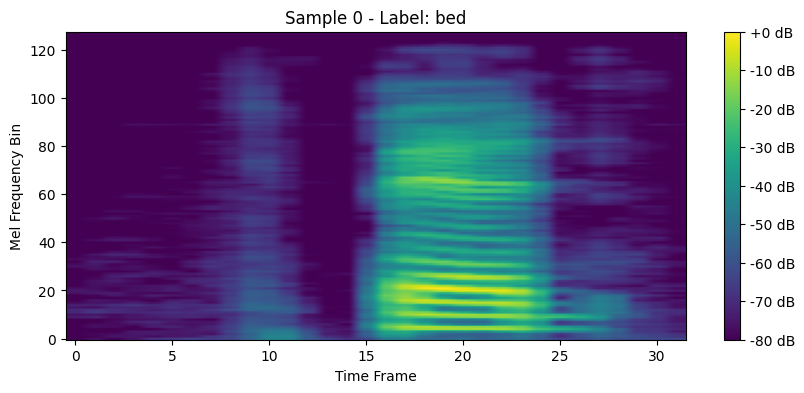

In [16]:

# Plot one sample
def plot_sample(x, y, label_map, index=0):
    plt.figure(figsize=(10, 4))
    plt.imshow(x[index], aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    
    # Get the label from the label map
    label = list(label_map.keys())[list(label_map.values()).index(y[index])]
    plt.title(f"Sample {index} - Label: {label}")
    
    plt.xlabel('Time Frame')
    plt.ylabel('Mel Frequency Bin')
    plt.show()

# Call the plot function
plot_sample(x, y, label_map, index=0)


## Train Test Split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)


In [18]:
print(f"train sample : {len(x_train)}, {len(y_train)}")


train sample : 8910, 8910


In [19]:
x_train = x_train[..., np.newaxis]

## Model

In [ ]:
def build_model(input_shape, num_classes):
    model = Sequential([

        Conv2D(32,(3,3), activation = "relu", input_shape = input_shape),
        MaxPooling2D((2,2)),
        Conv2D(64,(3,3),activation = "relu"),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),activation = "relu"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation = "relu"),
        Dropout(0.2),
        Dense(num_classes, activation = "softmax")
     ])
    return model

In [ ]:
model = build_model(x_train[0].shape, len(file_names))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
early = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

In [ ]:
epoch= 20
batch_size = 32

history = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = epoch, batch_size = batch_size, callbacks= [early])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(x_train, y_train)
print(f"Training Accuracy: {accuracy:.2f}")


## inference:

In [ ]:
index = random.randint(0, len(x_test) - 1)
sample = x_test[index]
true_label = y_test[index]

In [ ]:
sample_input = np.expand_dims(sample, axis = 0)

In [ ]:
prediction = model.predict(sample_input)
prediction_label = np.argmax(prediction)



In [ ]:
label_mappppp = {v : k for k, v for v in label_map.itme()}
print(f"Actual Label :{label_mappppp[true_label]}")
print(f"Predicted Label :{label_mappppp[prediction_label]}")

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
y_pred = np.argmax(model.predict(x_test), axis = 1)

In [ ]:
print(classification_report(y_test, y_pred, target_names = file_names))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels= file_names, yticklabels = file_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix")
plt.show()